In [1]:
import re
import pandas as pd
import analysis_relabel_funcs
from analysis import read_dfs
import torch
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from torch.nn import Softmax
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
import pickle
import time
%matplotlib inline

In [2]:
MODEL_RELABEL = {
    'BERT-Jigsaw': ["not toxic", "toxic"], 
    'BERT-SBIC-offensive': ["Not", "Maybe", "Offensive"],
    'BERT-SBIC-targetcategory': ['none', 'body', 'culture', 'disabled', 'gender', 'race', 'social', 'victim'], # not used
    'BERT-eec-emotion': ['none', 'anger','fear', 'joy', 'sadness'], # not used
    'BERT-jigsaw-identityhate': ['Not', "Yes"],
    'BERT-jigsaw-severetoxic': ["Not", "Yes"],
    'BERT-mdgender-convai-binary': ["female", "male"],
    'BERT-mdgender-convai-ternary': ["female", "male", "neutral"],
    'BERT-mdgender-wizard': ["neutral", "female", "male"],
    'BERT-rtgender-opgender-annotations': ["man", "woman"] 
}

In [3]:
def _softmax_and_relabel(predictions, categorical_labels):
    # takes in a torch.Tensor of predictions and a list of categorical labels, returns a tuple of (softmax tensor, categorical label)
    m = Softmax(dim=0)
    sm = m(predictions)
    return sm, categorical_labels[sm.argmax().item()]

def score(labels, predictions):
    softmax_preds, category = _softmax_and_relabel(predictions, labels)
    # scores are always the difference between the first and last
    return softmax_preds[-1] - softmax_preds[0], category

In [4]:
TOXIC_MODELS = {"Cameron/BERT-Jigsaw", 'Cameron/BERT-SBIC-offensive', 'Cameron/BERT-jigsaw-identityhate', 'Cameron/BERT-jigsaw-severetoxic'}
GENDER_MODELS = {'Cameron/BERT-mdgender-convai-binary', 'Cameron/BERT-mdgender-convai-ternary', 'Cameron/BERT-mdgender-wizard', 'Cameron/BERT-rtgender-opgender-annotations'}

In [5]:
FILES="""
Cameron-BERT-eec-emotion-00:40:36-conv_ai_3-train-eval.out
Cameron-BERT-eec-emotion-00:41:55-air_dialogue-train-eval.out
Cameron-BERT-eec-emotion-00:42:19-ted_talks_iwslt-train-eval.out
Cameron-BERT-eec-emotion-01:06:29-tweet_eval-train-eval.out
Cameron-BERT-eec-emotion-01:24:02-ted_talks_iwslt-train-eval.out
Cameron-BERT-Jigsaw-00:40:33-conv_ai_3-train-eval.out
Cameron-BERT-Jigsaw-00:41:54-air_dialogue-train-eval.out
Cameron-BERT-Jigsaw-00:42:14-ted_talks_iwslt-train-eval.out
Cameron-BERT-Jigsaw-01:08:42-tweet_eval-train-eval.out
Cameron-BERT-Jigsaw-01:15:29-ted_talks_iwslt-train-eval.out
Cameron-BERT-jigsaw-identityhate-00:40:35-conv_ai_3-train-eval.out
Cameron-BERT-jigsaw-identityhate-00:41:55-air_dialogue-train-eval.out
Cameron-BERT-jigsaw-identityhate-00:42:20-ted_talks_iwslt-train-eval.out
Cameron-BERT-jigsaw-identityhate-00:43:43-tweet_eval-train-eval.out
Cameron-BERT-jigsaw-identityhate-00:53:13-empathetic_dialogues-train-eval.out
Cameron-BERT-jigsaw-identityhate-01:32:40-ted_talks_iwslt-train-eval.out
Cameron-BERT-jigsaw-severetoxic-00:40:37-conv_ai_3-train-eval.out
Cameron-BERT-jigsaw-severetoxic-00:42:01-air_dialogue-train-eval.out
Cameron-BERT-jigsaw-severetoxic-00:42:21-ted_talks_iwslt-train-eval.out
Cameron-BERT-jigsaw-severetoxic-01:16:40-ted_talks_iwslt-train-eval.out
Cameron-BERT-mdgender-convai-binary-00:40:37-conv_ai_3-train-eval.out
Cameron-BERT-mdgender-convai-binary-00:42:04-air_dialogue-train-eval.out
Cameron-BERT-mdgender-convai-binary-00:42:19-ted_talks_iwslt-train-eval.out
Cameron-BERT-mdgender-convai-binary-00:43:41-tweet_eval-train-eval.out
Cameron-BERT-mdgender-convai-binary-00:53:18-empathetic_dialogues-train-eval.out
Cameron-BERT-mdgender-convai-binary-01:30:30-ted_talks_iwslt-train-eval.out
Cameron-BERT-mdgender-convai-ternary-00:40:41-conv_ai_3-train-eval.out
Cameron-BERT-mdgender-convai-ternary-00:42:00-air_dialogue-train-eval.out
Cameron-BERT-mdgender-convai-ternary-00:42:18-ted_talks_iwslt-train-eval.out
Cameron-BERT-mdgender-convai-ternary-01:16:10-ted_talks_iwslt-train-eval.out
Cameron-BERT-mdgender-wizard-00:40:34-conv_ai_3-train-eval.out
Cameron-BERT-mdgender-wizard-00:41:58-air_dialogue-train-eval.out
Cameron-BERT-mdgender-wizard-00:42:15-ted_talks_iwslt-train-eval.out
Cameron-BERT-mdgender-wizard-00:43:40-tweet_eval-train-eval.out
Cameron-BERT-mdgender-wizard-00:53:08-empathetic_dialogues-train-eval.out
Cameron-BERT-mdgender-wizard-01:14:09-ted_talks_iwslt-train-eval.out
Cameron-BERT-rtgender-opgender-annotations-00:30:31-conv_ai_3-train-eval.out
Cameron-BERT-rtgender-opgender-annotations-00:40:32-conv_ai_3-train-eval.out
Cameron-BERT-rtgender-opgender-annotations-00:42:00-air_dialogue-train-eval.out
Cameron-BERT-rtgender-opgender-annotations-00:42:14-ted_talks_iwslt-train-eval.out
Cameron-BERT-rtgender-opgender-annotations-01:17:11-ted_talks_iwslt-train-eval.out
Cameron-BERT-SBIC-offensive-00:40:33-conv_ai_3-train-eval.out
Cameron-BERT-SBIC-offensive-00:41:58-air_dialogue-train-eval.out
Cameron-BERT-SBIC-offensive-00:42:20-ted_talks_iwslt-train-eval.out
Cameron-BERT-SBIC-offensive-00:53:12-empathetic_dialogues-train-eval.out
Cameron-BERT-SBIC-offensive-01:08:26-tweet_eval-train-eval.out
Cameron-BERT-SBIC-offensive-01:31:48-ted_talks_iwslt-train-eval.out
Cameron-BERT-SBIC-targetcategory-00:40:41-conv_ai_3-train-eval.out
Cameron-BERT-SBIC-targetcategory-00:42:00-air_dialogue-train-eval.out
Cameron-BERT-SBIC-targetcategory-00:42:18-ted_talks_iwslt-train-eval.out
Cameron-BERT-SBIC-targetcategory-01:06:42-tweet_eval-train-eval.out
Cameron-BERT-SBIC-targetcategory-01:17:08-ted_talks_iwslt-train-eval.out
"""

In [6]:
eval_files = {}
toxic_files = []
gender_files = []

def create_tup(filename, model_name):
    return (model_name.replace("Cameron/", ""), "results/" + filename)

for filename in FILES.strip().split("\n"):
    s = filename.split(":")
    model_name = s[0][:-3]
    model_name = model_name.replace("Cameron-", "Cameron/")
    eval_dataset_name = s[-1][3:-15]
    model_type = None
    if eval_dataset_name not in eval_files:
        eval_files[eval_dataset_name] = {"toxic": [], "gender": []}
    if model_name in TOXIC_MODELS:
        model_type = "TOXIC"
        eval_files[eval_dataset_name]["toxic"].append(create_tup(filename, model_name))
        toxic_files.append(filename)
    elif model_name in GENDER_MODELS:
        model_type = "GENDER"
        eval_files[eval_dataset_name]["gender"].append(create_tup(filename, model_name))
        gender_files.append(filename)
    else:
        print(f"Model type is not classified, please classify {model_name} with file {filename}")
        continue
    print(f"Model name: {model_name} | eval dataset: {eval_dataset_name}" )

Model type is not classified, please classify Cameron/BERT-eec-emotion with file Cameron-BERT-eec-emotion-00:40:36-conv_ai_3-train-eval.out
Model type is not classified, please classify Cameron/BERT-eec-emotion with file Cameron-BERT-eec-emotion-00:41:55-air_dialogue-train-eval.out
Model type is not classified, please classify Cameron/BERT-eec-emotion with file Cameron-BERT-eec-emotion-00:42:19-ted_talks_iwslt-train-eval.out
Model type is not classified, please classify Cameron/BERT-eec-emotion with file Cameron-BERT-eec-emotion-01:06:29-tweet_eval-train-eval.out
Model type is not classified, please classify Cameron/BERT-eec-emotion with file Cameron-BERT-eec-emotion-01:24:02-ted_talks_iwslt-train-eval.out
Model name: Cameron/BERT-Jigsaw | eval dataset: conv_ai_3
Model name: Cameron/BERT-Jigsaw | eval dataset: air_dialogue
Model name: Cameron/BERT-Jigsaw | eval dataset: ted_talks_iwslt
Model name: Cameron/BERT-Jigsaw | eval dataset: tweet_eval
Model name: Cameron/BERT-Jigsaw | eval dat

In [7]:
print(f"Found {len(toxic_files)} toxic results and {len(gender_files)} gender files")

Found 21 toxic results and 21 gender files


In [8]:
eval_files

{'conv_ai_3': {'toxic': [('BERT-Jigsaw',
    'results/Cameron-BERT-Jigsaw-00:40:33-conv_ai_3-train-eval.out'),
   ('BERT-jigsaw-identityhate',
    'results/Cameron-BERT-jigsaw-identityhate-00:40:35-conv_ai_3-train-eval.out'),
   ('BERT-jigsaw-severetoxic',
    'results/Cameron-BERT-jigsaw-severetoxic-00:40:37-conv_ai_3-train-eval.out'),
   ('BERT-SBIC-offensive',
    'results/Cameron-BERT-SBIC-offensive-00:40:33-conv_ai_3-train-eval.out')],
  'gender': [('BERT-mdgender-convai-binary',
    'results/Cameron-BERT-mdgender-convai-binary-00:40:37-conv_ai_3-train-eval.out'),
   ('BERT-mdgender-convai-ternary',
    'results/Cameron-BERT-mdgender-convai-ternary-00:40:41-conv_ai_3-train-eval.out'),
   ('BERT-mdgender-wizard',
    'results/Cameron-BERT-mdgender-wizard-00:40:34-conv_ai_3-train-eval.out'),
   ('BERT-rtgender-opgender-annotations',
    'results/Cameron-BERT-rtgender-opgender-annotations-00:30:31-conv_ai_3-train-eval.out'),
   ('BERT-rtgender-opgender-annotations',
    'results/Came

In [9]:
def cross_tab_gender_toxic(eval_file_split, eval_dataset_name, return_one = False):
    eval_crosstabs = []
    count = 0.0
    tot = len(eval_file_split["toxic"]) * len(eval_file_split["gender"])
    for toxic_tup in eval_file_split["toxic"]:
        toxic_model_name = toxic_tup[0]
        toxic_filename = toxic_tup[1]
        for gender_tup in eval_file_split["gender"]:
            gender_model_name = gender_tup[0]
            gender_filename = gender_tup[1]
            
            # for using sbc and rt_gender for conv_ai
            _, _, combined = read_dfs(toxic_filename, 
                                      gender_filename,
                                     suffixes=("_" + toxic_model_name, "_" + gender_model_name))
            pred_toxic = "predictions_" + toxic_model_name
            pred_gender = "predictions_" + gender_model_name
            
            print("relabeling toxic")
            p = partial(score, MODEL_RELABEL[toxic_model_name])
            s = combined[pred_toxic].map(p)
            scores_col = f"scores_{toxic_model_name}"
            category_col = f"category_{toxic_model_name}"
            
            s = pd.DataFrame(s.tolist(), columns=[scores_col, category_col])
            s[scores_col] = s[scores_col].map(lambda x: x.item()) # comes back as a tensor, change it to float
            combined = combined.join(s)
            
            print("relabeling gender")
            p = partial(score, MODEL_RELABEL[gender_model_name])
            s = combined[pred_gender].map(p)
            scores_col = f"scores_{gender_model_name}"
            category_col = f"category_{gender_model_name}"
            
            s = pd.DataFrame(s.tolist(), columns=[scores_col, category_col])
            s[scores_col] = s[scores_col].map(lambda x: x.item()) # comes back as a tensor, change it to float
            combined = combined.join(s)
            
            
            eval_crosstabs.append({
                "toxic_attr": (f"scores_{toxic_model_name}", f"category_{toxic_model_name}"),
                "gender_attr": (f"scores_{gender_model_name}", f"category_{gender_model_name}"),
                "df": combined
            })
            count += 1.0
            print(f"Crossing {toxic_model_name} x {gender_model_name} for {eval_dataset_name}, finished {count/tot*100}%")
            if return_one:
                return eval_crosstabs
    return eval_crosstabs

In [ ]:
crosstabs = []
for eval_dataset_name, eval_f in eval_files.items():
    print(f"Analyzing {eval_dataset_name}")
    ct = cross_tab_gender_toxic(eval_f, eval_dataset_name, return_one=False)
    crosstabs.append((eval_dataset_name, ct))
    

Analyzing conv_ai_3
relabeling toxic
relabeling gender
Crossing BERT-Jigsaw x BERT-mdgender-convai-binary for conv_ai_3, finished 5.0%
relabeling toxic
relabeling gender
Crossing BERT-Jigsaw x BERT-mdgender-convai-ternary for conv_ai_3, finished 10.0%
relabeling toxic
relabeling gender
Crossing BERT-Jigsaw x BERT-mdgender-wizard for conv_ai_3, finished 15.0%
relabeling toxic
relabeling gender
Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for conv_ai_3, finished 20.0%
relabeling toxic
relabeling gender
Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for conv_ai_3, finished 25.0%
relabeling toxic


In [ ]:
pickle.dump(crosstabs, open(f"{time.time()}-pickle.p", "wb"))

In [12]:
def scale_and_generate(ct, dataset_name):
    toxic_score_col, toxic_category_col = ct["toxic_attr"]
    gender_score_col, gender_category_col = ct["gender_attr"]
    std_scaler = StandardScaler()
    df = ct["df"]
    
    # covariance 
    scores_df = df[[toxic_score_col, gender_score_col]]
    scores_df = pd.DataFrame(std_scaler.fit_transform(scores_df), columns=scores_df.columns)
    cov = scores_df.cov()
    print(f"{dataset_name} | {toxic_category_col} | {gender_category_col}")
    print(cov)
    
    # contingency 
    contingency = pd.crosstab(df[toxic_category_col], df[gender_category_col])
    c, p, dof, expected = chi2_contingency(contingency)
    print(f"p-value is {p}")
    
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(contingency, annot=True, fmt="d", cmap="YlGnBu")
    
    print("------------------------------")

conv_ai_3 | category_BERT-Jigsaw | category_BERT-mdgender-convai-binary
                                    scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                            1.000011   
scores_BERT-mdgender-convai-binary            0.023196   

                                    scores_BERT-mdgender-convai-binary  
scores_BERT-Jigsaw                                            0.023196  
scores_BERT-mdgender-convai-binary                            1.000011  
p-value is 0.0645255368395195
------------------------------
conv_ai_3 | category_BERT-Jigsaw | category_BERT-mdgender-convai-ternary
                                     scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                             1.000011   
scores_BERT-mdgender-convai-ternary           -0.026192   

                                     scores_BERT-mdgender-convai-ternary  
scores_BERT-Jigsaw                                             -0.026192  
scores_BERT-mdgender-convai-ternary                             1.000011

p-value is 2.84306294626341e-82
------------------------------
conv_ai_3 | category_BERT-SBIC-offensive | category_BERT-rtgender-opgender-annotations
                                           scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                                   1.040000   
scores_BERT-rtgender-opgender-annotations                    0.381272   

                                           scores_BERT-rtgender-opgender-annotations  
scores_BERT-SBIC-offensive                                                  0.381272  
scores_BERT-rtgender-opgender-annotations                                   1.040000  
p-value is 0.5957172893162241
------------------------------
conv_ai_3 | category_BERT-SBIC-offensive | category_BERT-rtgender-opgender-annotations
                                           scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                                   1.000011   
scores_BERT-rtgender-opgender-annotations                    0.076434   

 

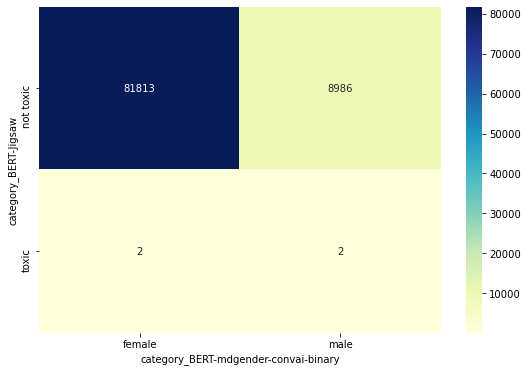

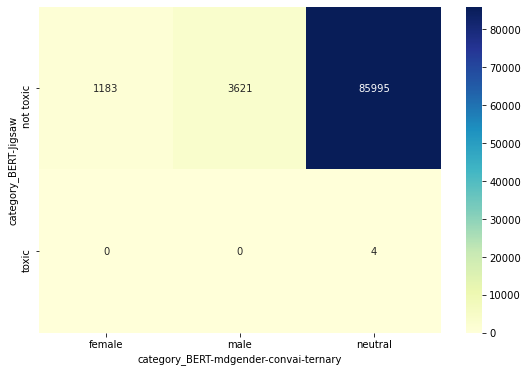

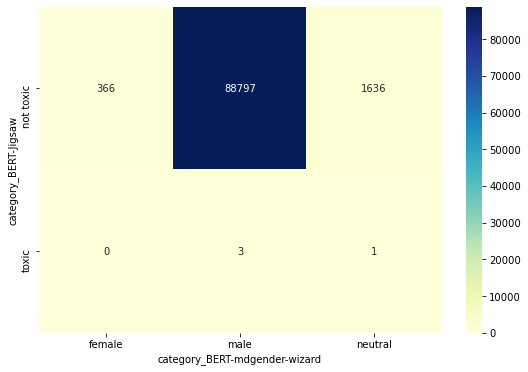

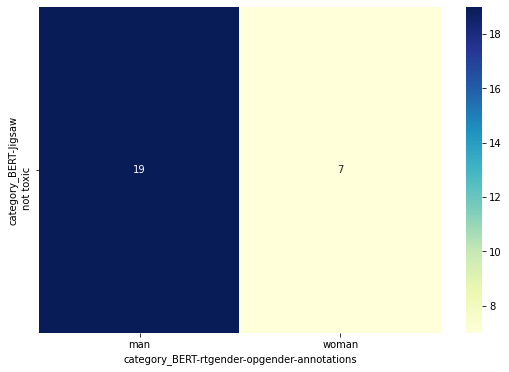

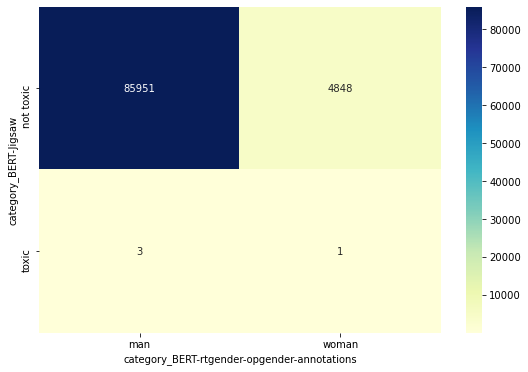

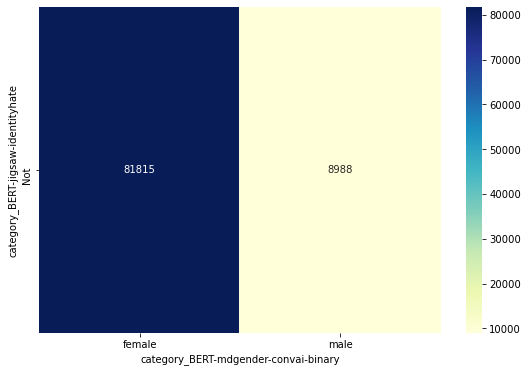

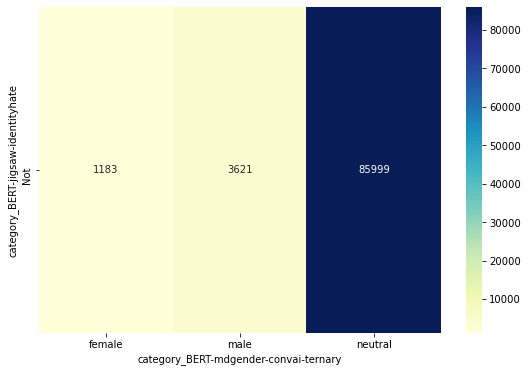

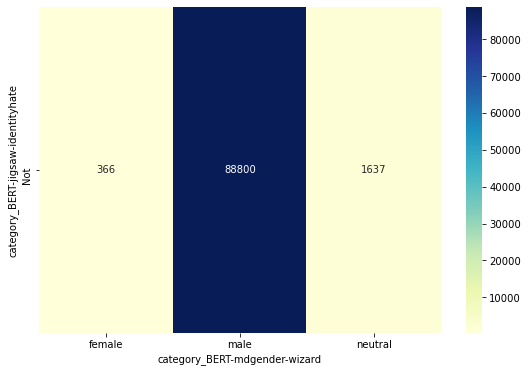

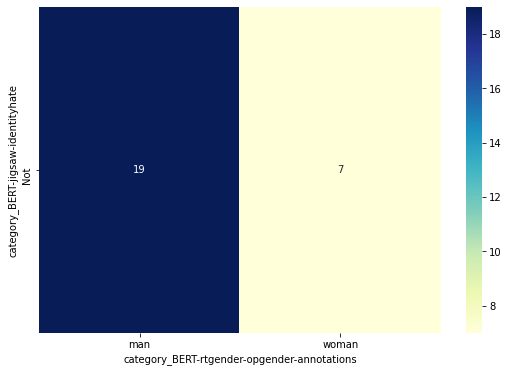

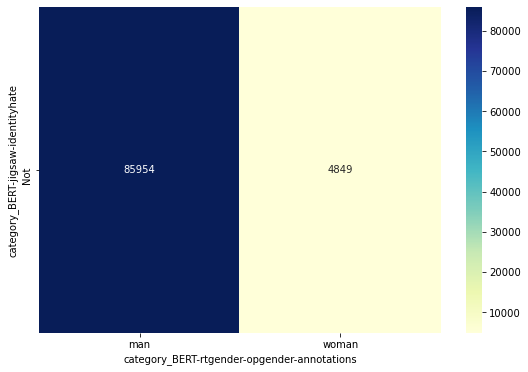

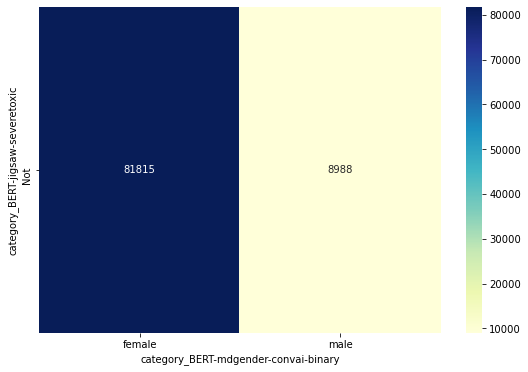

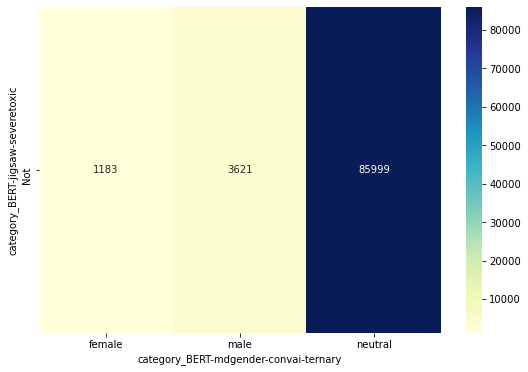

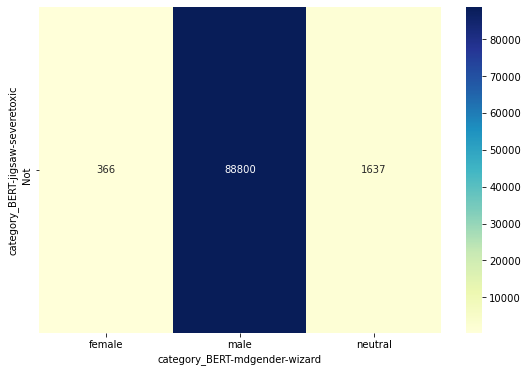

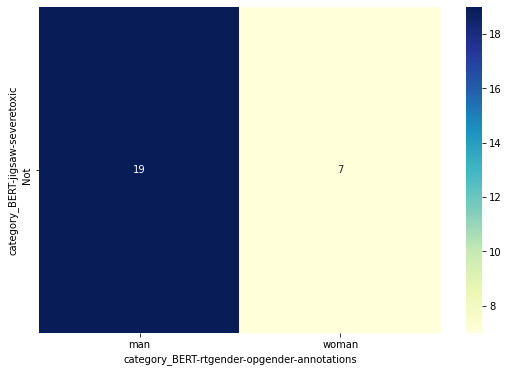

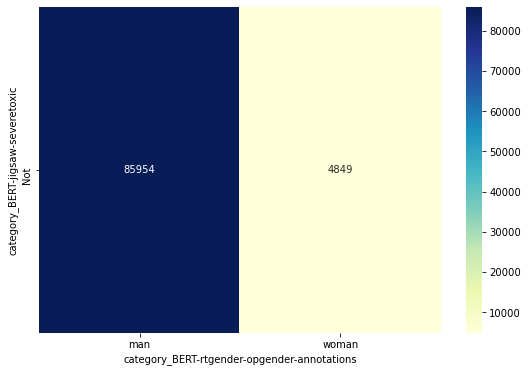

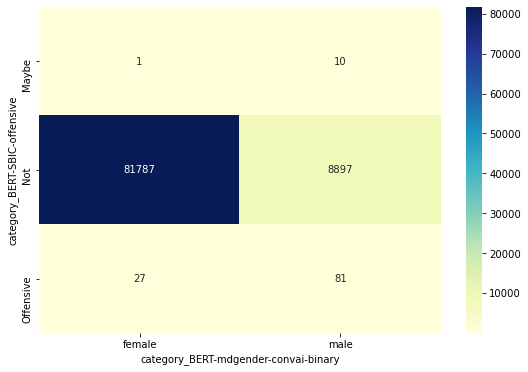

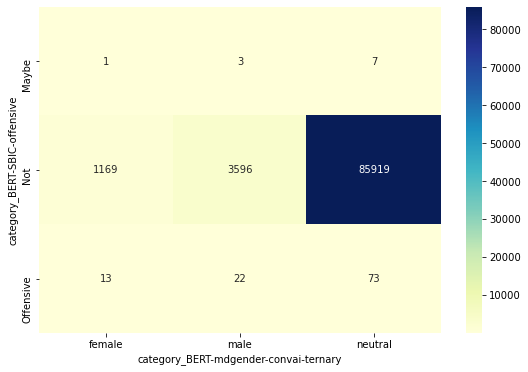

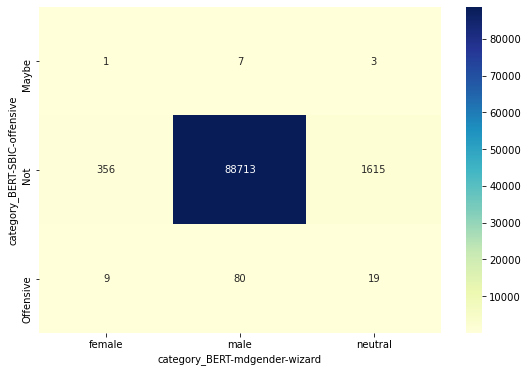

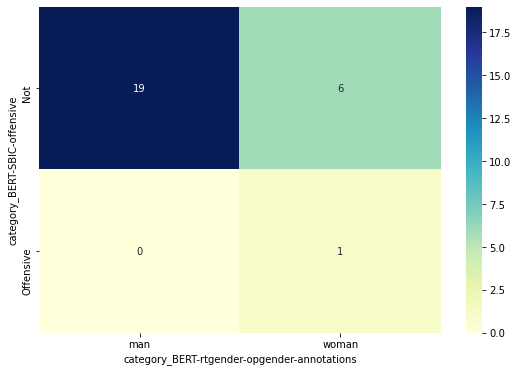

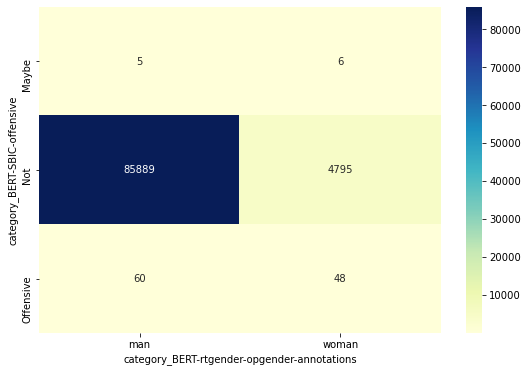

In [26]:
# for ct in crosstabs[0]:
#     scale_and_generate(ct, "conv_ai_3")

In [ ]:
# uncomment and change below to load a pickle and use that for analysis!
# crosstabs = pickle.load(open("####-pickle.p"))


In [19]:
for eval_dataset_name, ct_list in crosstabs: 
    for ct in ct_list:
        scale_and_generate(ct, eval_dataset_name)

{'toxic_attr': ('scores_BERT-Jigsaw', 'category_BERT-Jigsaw'),
 'gender_attr': ('scores_BERT-mdgender-convai-binary',
  'category_BERT-mdgender-convai-binary'),
 'df':                                                 sentence  \
 0                    yes am interested in obamas family    
 1             yes i want to know who made up his family    
 2                       yes this is what am looking for    
 3      no find the barack obamas family tree time mag...   
 4      no i need the specific time magazine article t...   
 ...                                                  ...   
 90798                 yes and the evolution there after    
 90799                                   that would help    
 90800                      no show me the history of it    
 90801  i would like to know how its evolved over the ...   
 90802                    just a timeline of it evolving    
 
                  predictions_BERT-Jigsaw  \
 0      [tensor(4.5893), tensor(-5.8416)]   
 1      [